# Powergrid library construction and zero gamma data

$\Gamma = 0$,

Perburbations = large

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import coo_array

## Loading data

#### Reading gamma values 

In [2]:
gamma_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_gamma.csv")

In [3]:
gamma_df

,gen_1,gen_2,term_1,term_2,load_1,load_2
0,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000


#### Reading time series data and skipping rows to sub sample

In [4]:
data_matrix_df_orig = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_timeseries.csv")

In [46]:
skip_n_rows_btw = 100
rows_to_keep = np.arange(0, len(data_matrix_df_orig), skip_n_rows_btw)

In [47]:
data_matrix_df = data_matrix_df_orig.iloc[rows_to_keep].reset_index(drop=True)

In [48]:
new_column_names = ["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                   "om_0", "om_1", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5",
                   "Q_0", "Q_1", "Q_2", "Q_3", "Q_4", "Q_5"]
data_matrix_df.rename(columns=dict((zip(data_matrix_df.columns, new_column_names))),
                     inplace=True)

In [49]:
data_matrix_df = data_matrix_df[["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                   "om_0", "om_1", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]]

data_matrix_df

,time,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,P_0,P_1,P_2,P_3,P_4,P_5
0,0.00000000,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,1.30553432,-0.82715001,-0.47838430
1,0.01000000,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,0.56095147,1.47360231,0.25887909,-0.09266137,-0.97515765,-1.22561386
2,0.02000000,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,0.97655598,2.16680957,0.00431959,-0.27718714,-1.30142939,-1.56906862
3,0.03000000,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,1.23405535,2.58075647,-0.15474827,-0.38378622,-1.49777509,-1.77850225
4,0.04000000,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,1.39417084,2.82415143,-0.25006607,-0.44760550,-1.61575711,-1.90489358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,19.94910000,0.98467621,0.92202215,0.77912741,0.79392211,0.75141845,0.73709091,-0.07412233,0.01070709,1.90720458,2.56547909,-0.25738417,-0.52062394,-1.69738082,-1.99729474
1996,19.95910000,0.98353273,0.92237444,0.77878826,0.79387849,0.75123987,0.73687157,-0.15376023,0.05937540,1.89984625,2.57336442,-0.25632736,-0.52209574,-1.69788815,-1.99689942
1997,19.96910000,0.98161980,0.92320057,0.77830622,0.79400736,0.75110072,0.73662528,-0.22776661,0.10531896,1.88675297,2.58725077,-0.25616343,-0.52283522,-1.69842423,-1.99658085
1998,19.97910000,0.97900083,0.92446878,0.77769559,0.79430070,0.75100263,0.73635797,-0.29475042,0.14765215,1.86836929,2.60666355,-0.25686770,-0.52284789,-1.69897544,-1.99634182


In [50]:
data_matrix_df.columns

Index(['time', 'Phi_0', 'Phi_1', 'Phi_2', 'Phi_3', 'Phi_4', 'Phi_5', 'om_0',
       'om_1', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5'],
      dtype='object')

#### Loading admittance matrix, Y

In [51]:
admittance_Y_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_Y.csv")
for column in admittance_Y_df.columns:
    admittance_Y_df[column] = admittance_Y_df[column].apply(lambda x: x.replace('i', 'j'))

In [52]:
admittance_Y_df

,gen_1,gen_2,term_1,term_2,load_1,load_2
0,0-9.3443j,0,-0+9.3443j,0,0,0
1,0,0-19.302j,0,-0+19.302j,0,0
2,-0+9.3443j,0,0-55.977j,0,0+19.841j,0+26.882j
3,0,-0+19.302j,0,0-61.805j,0+26.882j,0+15.723j
4,0,0,0+19.841j,0+26.882j,0-46.633j,0
5,0,0,0+26.882j,0+15.723j,0,0-42.502j


#### Loading static parameters

In [53]:
static_param_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_staticparams.csv")

In [54]:
static_param_df

,V,A,omega_R,D,H
0,1.00000000,1.82000000,376.99111843,50,7.28000000
1,1.02000000,3.18000000,376.99111843,50,12.72000000
2,1.00000000,-0.50000000,376.99111843,50,0.00000000
3,1.02000000,-0.80000000,376.99111843,50,0.00000000
4,0.98985198,-1.70000000,376.99111843,50,0.00000000
5,0.97876194,-2.00000000,376.99111843,50,0.00000000


#### Loading coupling matrix, K

In [55]:
coupling_K_df = pd.read_csv("powergrid/Datasets/case_4bus2gen_largeperturb/case_4bus2gen_K.csv")

In [56]:
coupling_K_df_labeled = coupling_K_df.set_index(coupling_K_df.columns)
coupling_K_df_labeled

,gen_1,gen_2,term_1,term_2,load_1,load_2
gen_1,0.00000000,0.00000000,10.51600000,0.00000000,0.00000000,0.00000000
gen_2,0.00000000,0.00000000,0.00000000,22.25500000,0.00000000,0.00000000
term_1,10.51600000,0.00000000,0.00000000,0.00000000,19.64000000,26.31100000
term_2,0.00000000,22.25500000,0.00000000,0.00000000,27.14100000,15.69700000
load_1,0.00000000,0.00000000,19.64000000,27.14100000,0.00000000,0.00000000
load_2,0.00000000,0.00000000,26.31100000,15.69700000,0.00000000,0.00000000


## Forming candidate library for powersystems

In [57]:
gamma_df

,gen_1,gen_2,term_1,term_2,load_1,load_2
0,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000


In [58]:
gamma_matrix = gamma_df.to_numpy()
admittance_Y_matrix = admittance_Y_df.to_numpy()

gamma_matrix

array([[-3.1416,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    , -3.1416,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , -3.1416,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , -3.1416,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , -3.1416,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , -3.1416]])

In [59]:
coupling_matrix_init = np.ones(admittance_Y_matrix.shape)
# coupling_matrix_init = np.zeros(admittance_Y_matrix.shape)
# coupling_matrix_init[3,:] = 1

coupling_matrix_init = np.triu(coupling_matrix_init, 0)
coupling_matrix_init
sparse_coupling_matrix_init = coo_array(coupling_matrix_init)
sparse_coupling_matrix_init.toarray()

array([[1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.]])

### Defining the sin interaction terms 

In [60]:
from dae_finder import FeatureCouplingTransformer

def coup_fun(x,y,i,j,gam_matrix):
    return np.sin(x-y- gam_matrix[i,j])

def coup_namer(x,y,i,j,gam_matrix):
    return "sin( {}-{} -gamma_{},{} )".format(x,y,i,j)
    

dummy_tr_sin_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
                                           coupling_func= coup_fun,
                                           coupling_namer= coup_namer,
                                           coupling_func_args={"gam_matrix":gamma_matrix},
                                              return_df=True)

In [61]:
sin_diff_library = dummy_tr_sin_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))
cop_ind = dummy_tr_sin_diff.coupled_indices_list

# cop_ind

In [62]:
sin_diff_library

,"sin( Phi_0-Phi_0 -gamma_0,0 )","sin( Phi_0-Phi_1 -gamma_0,1 )","sin( Phi_0-Phi_2 -gamma_0,2 )","sin( Phi_0-Phi_3 -gamma_0,3 )","sin( Phi_0-Phi_4 -gamma_0,4 )","sin( Phi_0-Phi_5 -gamma_0,5 )","sin( Phi_1-Phi_1 -gamma_1,1 )","sin( Phi_1-Phi_2 -gamma_1,2 )","sin( Phi_1-Phi_3 -gamma_1,3 )","sin( Phi_1-Phi_4 -gamma_1,4 )",...,"sin( Phi_2-Phi_2 -gamma_2,2 )","sin( Phi_2-Phi_3 -gamma_2,3 )","sin( Phi_2-Phi_4 -gamma_2,4 )","sin( Phi_2-Phi_5 -gamma_2,5 )","sin( Phi_3-Phi_3 -gamma_3,3 )","sin( Phi_3-Phi_4 -gamma_3,4 )","sin( Phi_3-Phi_5 -gamma_3,5 )","sin( Phi_4-Phi_4 -gamma_4,4 )","sin( Phi_4-Phi_5 -gamma_4,5 )","sin( Phi_5-Phi_5 -gamma_5,5 )"
0,-0.00000735,-0.03047592,0.00000000,-0.03047592,0.00000000,0.00000000,-0.00000735,0.03047592,0.00000000,0.03047592,...,-0.00000735,-0.03047592,0.00000000,0.00000000,-0.00000735,0.03047592,0.03047592,-0.00000735,0.00000000,-0.00000735
1,-0.00000735,-0.03020705,0.06003168,0.04322005,0.07108834,0.08286313,-0.00000735,0.09015685,0.07337915,0.10118652,...,-0.00000735,-0.01683348,0.01108033,0.02288846,-0.00000735,0.02791120,0.03971428,-0.00000735,0.01180963,-0.00000735
2,-0.00000735,-0.02924873,0.10450867,0.07877380,0.11726059,0.13201955,-0.00000735,0.13355252,0.10789793,0.14625736,...,-0.00000735,-0.02584148,0.01283078,0.02770269,-0.00000735,0.03866585,0.05352500,-0.00000735,0.01487455,-0.00000735
3,-0.00000735,-0.02769033,0.13206563,0.10100073,0.14580929,0.16239710,-0.00000735,0.15946278,0.12851073,0.17314777,...,-0.00000735,-0.03127423,0.01387793,0.03066214,-0.00000735,0.04514236,0.06190667,-0.00000735,0.01678778,-0.00000735
4,-0.00000735,-0.02563181,0.14920081,0.11520748,0.16367286,0.18130451,-0.00000735,0.17449670,0.14063077,0.18890524,...,-0.00000735,-0.03428939,0.01465208,0.03254705,-0.00000735,0.04892917,0.06679914,-0.00000735,0.01789925,-0.00000735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.00000735,0.06261307,0.20410444,0.18959937,0.23114828,0.24506361,-0.00000735,0.14240895,0.12774998,0.16977731,...,-0.00000735,-0.01479416,0.02770541,0.04202412,-0.00000735,0.04249086,0.05680061,-0.00000735,0.01432705,-0.00000735
1996,-0.00000735,0.06112017,0.20331697,0.18851935,0.23020940,0.24416755,-0.00000735,0.14309330,0.12814264,0.17030045,...,-0.00000735,-0.01508965,0.02754490,0.04190443,-0.00000735,0.04262570,0.05697605,-0.00000735,0.01436782,-0.00000735
1997,-0.00000735,0.05838600,0.20191576,0.18651377,0.22848290,0.24255100,-0.00000735,0.14438788,0.12883412,0.17125156,...,-0.00000735,-0.01570049,0.02720215,0.04166887,-0.00000735,0.04289347,0.05735059,-0.00000735,0.01447493,-0.00000735
1998,-0.00000735,0.05450503,0.19994838,0.18365177,0.22602798,0.24026890,-0.00000735,0.14624678,0.12980080,0.17259750,...,-0.00000735,-0.01660435,0.02668979,0.04132585,-0.00000735,0.04328454,0.05791032,-0.00000735,0.01464414,-0.00000735


In [63]:
candidate_lib = pd.concat([data_matrix_df.drop("time", axis=1), sin_diff_library], axis=1)

In [64]:
candidate_lib

,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,P_0,P_1,...,"sin( Phi_2-Phi_2 -gamma_2,2 )","sin( Phi_2-Phi_3 -gamma_2,3 )","sin( Phi_2-Phi_4 -gamma_2,4 )","sin( Phi_2-Phi_5 -gamma_2,5 )","sin( Phi_3-Phi_3 -gamma_3,3 )","sin( Phi_3-Phi_4 -gamma_3,4 )","sin( Phi_3-Phi_5 -gamma_3,5 )","sin( Phi_4-Phi_4 -gamma_4,4 )","sin( Phi_4-Phi_5 -gamma_4,5 )","sin( Phi_5-Phi_5 -gamma_5,5 )"
0,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,...,-0.00000735,-0.03047592,0.00000000,0.00000000,-0.00000735,0.03047592,0.03047592,-0.00000735,0.00000000,-0.00000735
1,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,0.56095147,1.47360231,...,-0.00000735,-0.01683348,0.01108033,0.02288846,-0.00000735,0.02791120,0.03971428,-0.00000735,0.01180963,-0.00000735
2,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,0.97655598,2.16680957,...,-0.00000735,-0.02584148,0.01283078,0.02770269,-0.00000735,0.03866585,0.05352500,-0.00000735,0.01487455,-0.00000735
3,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,1.23405535,2.58075647,...,-0.00000735,-0.03127423,0.01387793,0.03066214,-0.00000735,0.04514236,0.06190667,-0.00000735,0.01678778,-0.00000735
4,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,1.39417084,2.82415143,...,-0.00000735,-0.03428939,0.01465208,0.03254705,-0.00000735,0.04892917,0.06679914,-0.00000735,0.01789925,-0.00000735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.98467621,0.92202215,0.77912741,0.79392211,0.75141845,0.73709091,-0.07412233,0.01070709,1.90720458,2.56547909,...,-0.00000735,-0.01479416,0.02770541,0.04202412,-0.00000735,0.04249086,0.05680061,-0.00000735,0.01432705,-0.00000735
1996,0.98353273,0.92237444,0.77878826,0.79387849,0.75123987,0.73687157,-0.15376023,0.05937540,1.89984625,2.57336442,...,-0.00000735,-0.01508965,0.02754490,0.04190443,-0.00000735,0.04262570,0.05697605,-0.00000735,0.01436782,-0.00000735
1997,0.98161980,0.92320057,0.77830622,0.79400736,0.75110072,0.73662528,-0.22776661,0.10531896,1.88675297,2.58725077,...,-0.00000735,-0.01570049,0.02720215,0.04166887,-0.00000735,0.04289347,0.05735059,-0.00000735,0.01447493,-0.00000735
1998,0.97900083,0.92446878,0.77769559,0.79430070,0.75100263,0.73635797,-0.29475042,0.14765215,1.86836929,2.60666355,...,-0.00000735,-0.01660435,0.02668979,0.04132585,-0.00000735,0.04328454,0.05791032,-0.00000735,0.01464414,-0.00000735


### Removing zero features

In [65]:
non_zero_column_series = (candidate_lib**2).sum() > 0.00001
non_zero_column_series
non_columns = [column for column in candidate_lib if non_zero_column_series[column]]

candidate_lib = candidate_lib[non_columns]

In [66]:
candidate_lib

,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,P_0,P_1,...,"sin( Phi_1-Phi_2 -gamma_1,2 )","sin( Phi_1-Phi_3 -gamma_1,3 )","sin( Phi_1-Phi_4 -gamma_1,4 )","sin( Phi_1-Phi_5 -gamma_1,5 )","sin( Phi_2-Phi_3 -gamma_2,3 )","sin( Phi_2-Phi_4 -gamma_2,4 )","sin( Phi_2-Phi_5 -gamma_2,5 )","sin( Phi_3-Phi_4 -gamma_3,4 )","sin( Phi_3-Phi_5 -gamma_3,5 )","sin( Phi_4-Phi_5 -gamma_4,5 )"
0,0.00000000,0.03048064,0.00000000,0.03048064,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,...,0.03047592,0.00000000,0.03047592,0.03047592,-0.03047592,0.00000000,0.00000000,0.03047592,0.03047592,0.00000000
1,0.00207317,0.03228481,-0.05799463,-0.04116035,-0.06907518,-0.08088508,0.38409320,0.32207273,0.56095147,1.47360231,...,0.09015685,0.07337915,0.10118652,0.11292848,-0.01683348,0.01108033,0.02288846,0.02791120,0.03971428,0.01180963
2,0.00714632,0.03639922,-0.09755353,-0.07170918,-0.11038467,-0.12525976,0.60913700,0.48141153,0.97655598,2.16680957,...,0.13355252,0.10789793,0.14625736,0.16095578,-0.02584148,0.01283078,0.02770269,0.03866585,0.05352500,0.01487455
3,0.01391813,0.04161200,-0.11853445,-0.08725512,-0.13241283,-0.14920139,0.73206815,0.54963974,1.23405535,2.58075647,...,0.15946278,0.12851073,0.17314777,0.18965759,-0.03127423,0.01387793,0.03066214,0.04514236,0.06190667,0.01678778
4,0.02158021,0.04721482,-0.12817977,-0.09388366,-0.14283237,-0.16073258,0.79225983,0.56424640,1.39417084,2.82415143,...,0.17449670,0.14063077,0.18890524,0.20645196,-0.03428939,0.01465208,0.03254705,0.04892917,0.06679914,0.01789925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.98467621,0.92202215,0.77912741,0.79392211,0.75141845,0.73709091,-0.07412233,0.01070709,1.90720458,2.56547909,...,0.14240895,0.12774998,0.16977731,0.18387895,-0.01479416,0.02770541,0.04202412,0.04249086,0.05680061,0.01432705
1996,0.98353273,0.92237444,0.77878826,0.79387849,0.75123987,0.73687157,-0.15376023,0.05937540,1.89984625,2.57336442,...,0.14309330,0.12814264,0.17030045,0.18444081,-0.01508965,0.02754490,0.04190443,0.04262570,0.05697605,0.01436782
1997,0.98161980,0.92320057,0.77830622,0.79400736,0.75110072,0.73662528,-0.22776661,0.10531896,1.88675297,2.58725077,...,0.14438788,0.12883412,0.17125156,0.18549471,-0.01570049,0.02720215,0.04166887,0.04289347,0.05735059,0.01447493
1998,0.97900083,0.92446878,0.77769559,0.79430070,0.75100263,0.73635797,-0.29475042,0.14765215,1.86836929,2.60666355,...,0.14624678,0.12980080,0.17259750,0.18700336,-0.01660435,0.02668979,0.04132585,0.04328454,0.05791032,0.01464414


## Smoothening data and finding derivatives using splines

In [67]:
from dae_finder import add_noise_to_df

noise_perc = 0
data_matrix_df_list = [data_matrix_df]
num_time_points = len(data_matrix_df)
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["time"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["time"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [68]:
from dae_finder import smooth_data

# Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix, domain_var="time", derr_order=1, noise_perc=noise_perc) for
                              data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) > 1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
# if "time" in data_matrix_df_smooth:
#     data_matrix_df_smooth = data_matrix_df_smooth.drop("time", axis=1)

In [69]:
data_matrix_df_smooth - data_matrix_df

,time,Phi_0,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,om_0,om_1,P_0,P_1,P_2,P_3,P_4,P_5
0,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000
1,-0.00000045,-0.00000017,-0.00000014,0.00000221,0.00000207,0.00000242,0.00000268,-0.00001326,-0.00001024,-0.00002224,-0.00004425,0.00000576,0.00002490,0.00001372,0.00002210
2,-0.00000090,-0.00000055,-0.00000043,0.00000266,0.00000184,0.00000273,0.00000289,-0.00001493,-0.00000942,-0.00002986,-0.00004540,0.00002260,0.00000488,0.00002522,0.00002257
3,-0.00000135,-0.00000099,-0.00000074,0.00000191,0.00000144,0.00000205,0.00000227,-0.00001168,-0.00000499,-0.00002685,-0.00004347,0.00001473,0.00001399,0.00001927,0.00002233
4,-0.00000180,-0.00000143,-0.00000102,0.00000103,0.00000062,0.00000115,0.00000129,-0.00000680,0.00000068,-0.00002270,-0.00003249,0.00001368,0.00000770,0.00001661,0.00001721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.00000180,-0.00000013,0.00000002,-0.00000005,-0.00000002,-0.00000004,-0.00000004,-0.00001476,0.00000895,-0.00000079,0.00000086,0.00000027,-0.00000033,-0.00000009,0.00000008
1996,0.00000135,-0.00000021,0.00000008,-0.00000006,0.00000001,-0.00000002,-0.00000003,-0.00001041,0.00000641,-0.00000139,0.00000148,0.00000008,-0.00000015,-0.00000007,0.00000005
1997,0.00000090,-0.00000021,0.00000009,-0.00000005,0.00000002,-0.00000001,-0.00000002,-0.00000637,0.00000399,-0.00000142,0.00000151,-0.00000002,-0.00000003,-0.00000005,0.00000003
1998,0.00000045,-0.00000013,0.00000007,-0.00000003,0.00000002,-0.00000000,-0.00000001,-0.00000284,0.00000181,-0.00000094,0.00000099,-0.00000005,0.00000002,-0.00000002,0.00000001


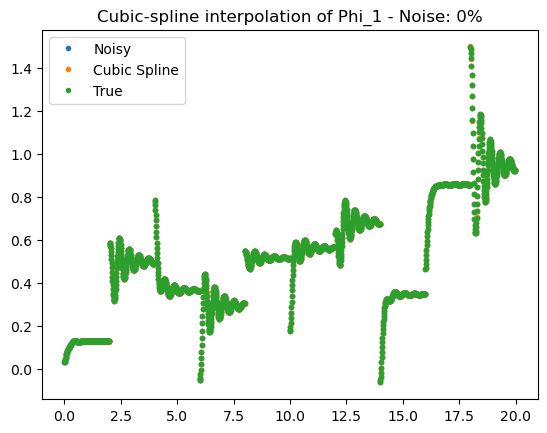

In [70]:
ind = 0
feature_ = "Phi_1"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["time"], data_matrix_df_list[ind][feature_], ".",
         data_matrix_smooth_df_list[ind]["time"],
         data_matrix_smooth_df_list[ind][feature_], ".",
         data_matrix_df[ind * num_time_points:(ind + 1) * num_time_points]["time"],
         data_matrix_df[ind * num_time_points:(ind + 1) * num_time_points][feature_], ".")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

### Removing some of the outliers coming from sudden jump during perturbations


<Axes: >

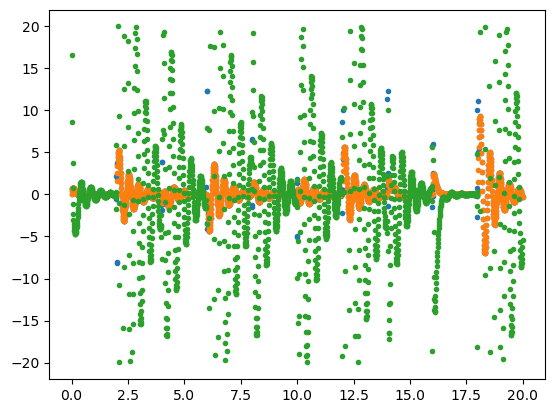

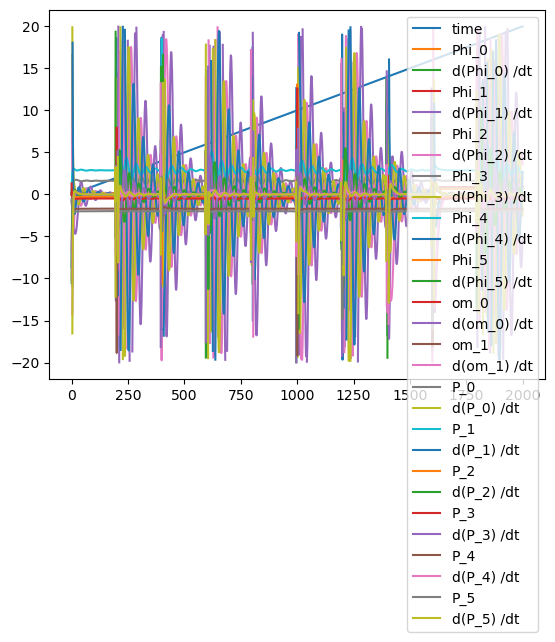

In [71]:
new_df = data_matrix_df_smooth_appended[abs(data_matrix_df_smooth_appended) <= 20]

plt.plot(new_df[["time"]], new_df[["d(Phi_0) /dt"]], ".",
         new_df[["time"]], new_df[["om_0"]], ".",
         new_df[["time"]], new_df[["d(om_0) /dt"]], ".")

new_df.plot()

## Finding Algebraic relationship

### Using sympy to find factors of redundant feature and refine the library

In [72]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [73]:
refined_candid_lib = data_matrix_df_smooth_appended[['Phi_0', 'Phi_1', 'Phi_2', 'Phi_3', 'Phi_4', 'Phi_5', 'om_0',
                                                     'om_1', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']]

In [74]:
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib), columns=s_scaler.feature_names_in_)

# Using Lasso

## Finding the conservation laws

In [75]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       alpha=0.3,
                                       fit_intercept=True)

In [76]:
features_to_fit_ = ["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
                    "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# features_to_fit_ = ["P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
num_nodes = 6
power_features = ["P_{}".format(ind) for ind in range(num_nodes)]
# Mapping each power feature to possible expressions in the algebraic relationship
feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features) for power_feat in power_features}

algebraic_model_lasso.fit(candidate_lib, scale_columns=True,
                          features_to_fit=features_to_fit_,
                          feature_to_library_map=feature_to_libr_map)

AlgModelFinder(alpha=0.3, fit_intercept=True)

In [77]:
algebraic_model_lasso.best_models()

,P_1,P_0,Phi_3,Phi_2,Phi_5,P_4,P_5,Phi_4,Phi_1,Phi_0,P_3,P_2
Phi_0,-0.00000000,0.00000000,0.00000000,0.11963627,0.00136898,-0.00000000,0.00000000,0.00000000,0.00000000,NaN,-0.00000000,-0.00000000
Phi_1,0.00000000,-0.00000000,0.24995893,0.00000000,0.00000000,0.00000000,-0.00000000,0.23218123,NaN,0.00000000,-0.00000000,0.00000000
Phi_2,-0.00000000,-0.00000000,0.44391535,NaN,0.25859731,-0.00000000,-0.00000000,0.10003535,0.00000000,0.58797160,0.00000000,0.00000000
Phi_3,-0.00000000,-0.00000000,NaN,0.45758516,0.15174173,-0.00000000,-0.00000000,0.00000000,0.40136451,0.00000000,0.00000000,0.00000000
Phi_4,0.00000000,-0.00000000,0.00000000,0.01215904,0.27207434,0.00000000,0.00000000,NaN,0.29260425,0.00000000,-0.00000000,-0.00000000
Phi_5,-0.00000000,0.00000000,0.00000000,0.09912458,NaN,0.00000000,0.00000000,0.35769058,0.00000000,0.09151365,-0.00000000,-0.00000000
om_0,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000
om_1,-0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000
"sin( Phi_0-Phi_1 -gamma_0,1 )",-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000
"sin( Phi_0-Phi_2 -gamma_0,2 )",-0.00000000,6.54098071,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.13803998,-0.00000000,-1.70205449


In [82]:
feat = "P_5"
algebraic_model_lasso.best_models()[feat][abs(algebraic_model_lasso.best_models()[feat])>0.1]

sin( Phi_2-Phi_5 -gamma_2,5 )   -18.54125860
sin( Phi_3-Phi_5 -gamma_3,5 )    -8.80557442
r2- metric                        0.87704462
Name: P_5, dtype: float64

## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

In [64]:
from sklearn.linear_model import Lasso

alg_lasso = Lasso(fit_intercept=True, alpha=0.3)
alg_lasso.fit(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.993372962219676

In [66]:
coef_dict = dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))
coef_dict

{'Phi_0': -0.0,
 'Phi_1': 0.0,
 'Phi_2': -0.0,
 'Phi_3': -0.0,
 'Phi_4': -0.0,
 'Phi_5': -0.0,
 'om_0': -4.378569736500431,
 'om_1': 0.0,
 'P_0': -21.257906402869075,
 'P_1': 0.0,
 'P_2': -0.6586577243676952,
 'P_3': -0.0,
 'P_4': 0.0,
 'P_5': 0.0}

In [67]:
seq_th_model.intercept_

43.934898759814715

In [68]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

['om_0', 'P_0', 'P_2']

In [69]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.9941958733407162

In [70]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'om_0': -4.794440359929478,
 'P_0': -21.691899870238316,
 'P_2': -1.032076931283162}

### Full candidate library is unable to find the model 

In [42]:
alg_lasso.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.9942246455235572

In [43]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

{'Phi_0': -0.0,
 'Phi_1': 0.0,
 'Phi_2': -0.0,
 'Phi_3': -0.0,
 'Phi_4': -0.0,
 'Phi_5': -0.0,
 'om_0': -4.42511229895725,
 'om_1': 0.0,
 'P_0': -16.11820529841526,
 'P_1': 0.0,
 'P_2': 0.0,
 'P_3': -0.0,
 'P_4': 0.0,
 'P_5': -0.0,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': -0.0,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': -0.07085153655901995,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': -0.0,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': -1.8898225265120703,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -3.234378209313293,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': 0.0,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': 0.0,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': 0.0,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': 0.0,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': -0.0,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': -0.0,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': -0.0,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': 0.0,
 'sin( Phi_3-Phi_5 -gamma_3,5 )': 0.0,
 'sin( Phi_4-Phi_5 -gamma_4,5 )': 0.0}

# Using Sequential Thresholding

## Finding the conservation laws

In [44]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)
seq_th_model = sequentialThLin(coef_threshold=0.1, fit_intercept=True)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

In [45]:
algebraic_model_th.fit(candidate_lib, scale_columns=True,
                       features_to_fit=features_to_fit_,
                       feature_to_library_map=feature_to_libr_map)


Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x11afd4f80>)

In [46]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models()

,P_0,P_1,P_4,P_5,P_3,P_2,Phi_3,Phi_4,Phi_5,Phi_0,Phi_2,Phi_1
Phi_0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.18179678,0.00000000
Phi_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.57822022,0.43500942,0.00000000,-0.27415651,NaN
Phi_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00006769,0.00000000,0.56458149,1.00140163,NaN,-1.11029393
Phi_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.72142625,1.52043686
Phi_4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.25290179,0.58659892
Phi_5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.42135215,NaN,0.00000000,0.11627801,0.00000000
om_0,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
om_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_0-Phi_1 -gamma_0,1 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_0-Phi_2 -gamma_0,2 )",9.34379096,0.00000000,0.00000000,0.00000000,0.00000000,-9.34297629,0.00000000,0.00000000,0.00000000,0.51555645,0.00000000,0.00000000


In [47]:
algebraic_model_th.get_fitted_intercepts()

{'Phi_0': -0.004487649967670191,
 'Phi_1': 0.1391496812135795,
 'Phi_2': 0.0035993399844953073,
 'Phi_3': -0.00025662259685728384,
 'Phi_4': 0.0015588337754553695,
 'Phi_5': 0.008787885981252679,
 'P_0': 8.012605982618121e-05,
 'P_1': 0.0001432537724332799,
 'P_2': -0.00012499810839002403,
 'P_3': -0.00012416838330224158,
 'P_4': -8.885831618496361e-05,
 'P_5': -0.00011506684743742915}

In [54]:
feat = "P_3"
algebraic_model_th.best_models()[feat][abs(algebraic_model_th.best_models()[feat]) > 0.1]

sin( Phi_1-Phi_3 -gamma_1,3 )   -20.07971708
sin( Phi_3-Phi_4 -gamma_3,4 )    27.14019081
sin( Phi_3-Phi_5 -gamma_3,5 )    15.69470275
r2- metric                        0.99999999
Name: P_3, dtype: float64

## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

In [56]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)
seq_th_model = sequentialThLin(model_id="lasso", coef_threshold=0.1, fit_intercept=True)

seq_th_model.fit(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
seq_th_model.score(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

Sequential threshold converged in 1 iterations


0.9861173018370403

In [57]:
coef_dict = dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))
coef_dict

{'Phi_0': 0.0,
 'Phi_1': 0.0,
 'Phi_2': 0.0,
 'Phi_3': 0.0,
 'Phi_4': 0.0,
 'Phi_5': 0.0,
 'om_0': -3.4265790184989955,
 'om_1': 0.0,
 'P_0': -20.273842484145458,
 'P_1': 0.0,
 'P_2': 0.0,
 'P_3': 0.0,
 'P_4': 0.0,
 'P_5': 0.0}

In [58]:
seq_th_model.intercept_

43.67131166721149

In [59]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

['om_0', 'P_0']

In [60]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])

0.991855949164572

In [61]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'om_0': -4.706282780743189, 'P_0': -21.55353230528021}

### Full candidate library is unable to find the model 

In [62]:
seq_th_model.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
seq_th_model.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

Sequential threshold converged in 2 iterations


0.988885520759928

In [63]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'Phi_0': 0.0,
 'Phi_1': 0.0,
 'Phi_2': 0.0,
 'Phi_3': 0.0,
 'Phi_4': 0.0,
 'Phi_5': 0.0,
 'om_0': -3.513639923413333,
 'om_1': 0.0,
 'P_0': -16.19834499489593,
 'P_1': 0.0,
 'P_2': 0.0,
 'P_3': 0.0,
 'P_4': 0.0,
 'P_5': 0.0,
 'sin( Phi_0-Phi_1 -gamma_0,1 )': 0.0,
 'sin( Phi_0-Phi_2 -gamma_0,2 )': 0.0,
 'sin( Phi_0-Phi_3 -gamma_0,3 )': 0.0,
 'sin( Phi_0-Phi_4 -gamma_0,4 )': -1.3982756870160125,
 'sin( Phi_0-Phi_5 -gamma_0,5 )': -2.7962471849994524,
 'sin( Phi_1-Phi_2 -gamma_1,2 )': 0.0,
 'sin( Phi_1-Phi_3 -gamma_1,3 )': 0.0,
 'sin( Phi_1-Phi_4 -gamma_1,4 )': 0.0,
 'sin( Phi_1-Phi_5 -gamma_1,5 )': 0.0,
 'sin( Phi_2-Phi_3 -gamma_2,3 )': 0.0,
 'sin( Phi_2-Phi_4 -gamma_2,4 )': 0.0,
 'sin( Phi_2-Phi_5 -gamma_2,5 )': 0.0,
 'sin( Phi_3-Phi_4 -gamma_3,4 )': 0.0,
 'sin( Phi_3-Phi_5 -gamma_3,5 )': 0.0,
 'sin( Phi_4-Phi_5 -gamma_4,5 )': 0.0}